# GLM Mixture: Negative Binomial/ Gamma-Poisson model

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from PIL import Image
from theano import shared
import arviz as az
from scipy.special import expit as logistic
import theano.tensor as tt

#### A negative-binomial model, more usefully called a gamma-Poisson model, assumes that each Poisson count observation has its own rate. It estimates the shape of a gamma distribution to describe the poisson rates across cases. Predictors adjust the shape of this distribution and not the expected value of each observation. It will look like this:
$$y_{i} \sim Gamma-Poisson(\lambda_{i}, \phi)$$

#### $\lambda$ is a rate parameter like in a normal Poisson distribution. The $\phi$ parameter must be positive and it controls the variance. The variance of the Gamma-Poisson is $\lambda + \lambda^{2}/\phi$ so larger $\phi$ values mean the distribution is more similar to a pure Poisson process. Remember that if $X \sim Poisson(\lambda)$ then $E(X) = Var(X) = \lambda$.

#### Let's revisit the Kline dataset.

In [2]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/Kline.csv'), delimiter=";")
    data["P"] = standardise(np.log(data['population']))
    data["cid"] = (data['contact']=='high').astype(int)
    
    return data

In [3]:
data = data_proc()
data.head()

,culture,population,contact,total_tools,mean_TU,P,cid
0,Malekula,1100,low,13,3.2,-1.291473,0
1,Tikopia,1500,low,22,4.7,-1.088551,0
2,Santa Cruz,3600,low,24,4.0,-0.515765,0
3,Yap,4791,high,43,5.0,-0.328773,1
4,Lau Fiji,7400,high,33,5.0,-0.044339,1


In [4]:
contact_id = (data.contact == "high").astype(int).values
P = data.P
#P must be > 0
P = P + np.abs(P.min()) + 0.1

In [5]:
with pm.Model() as m_12_6:
    a = pm.Normal("a", 1, 1, shape=2)
    b = pm.Exponential("b", 1, shape=2)
    
    g = pm.Exponential("g", 1)
    phi = pm.Exponential("phi", 1)
    cid = pm.intX(pm.Data("cid", contact_id))
    
    P_ = pm.Data("P_", P)
    
    _lambda = (tt.exp(a[cid])*P_**b[cid])/g
    
    T = pm.NegativeBinomial("total_tools", _lambda, phi, observed=data.total_tools)
    
    trace_12_2 = pm.sample(2_000, tune=2_000, target_accept=0.9, random_seed=8_927)
    

<ipython-input-5-11f63ea5583f>:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_12_2 = pm.sample(2_000, tune=2_000, target_accept=0.9, random_seed=8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, g, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 15 seconds.


In [6]:
#grab pareto k values
pareto_k = az.loo(trace_12_2, pointwise=True).pareto_k.values

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [7]:
pareto_k

array([0.67023441, 0.32551676, 0.30180101, 0.4811048 , 0.17108771,
       0.22494417, 0.24463093, 0.37652919, 0.29394517, 0.76955124])

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'g'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>]], dtype=object)

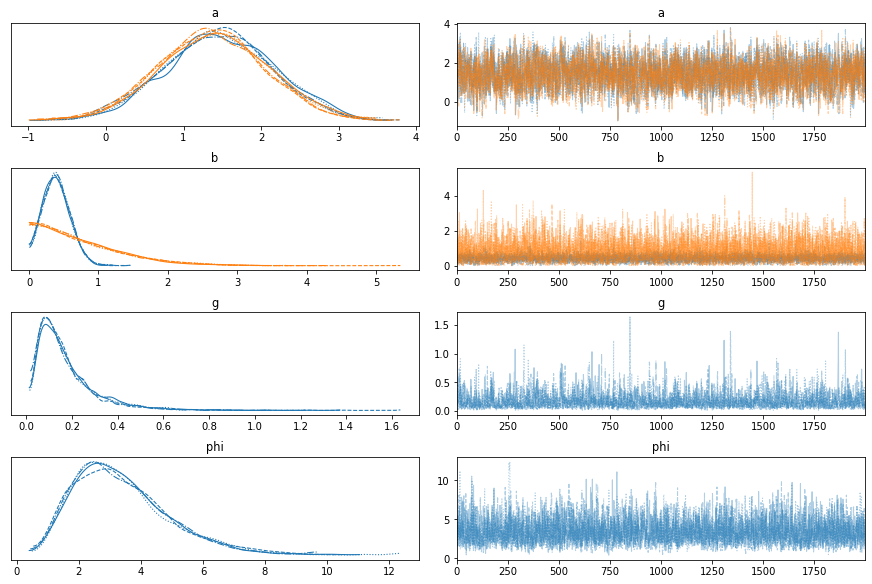

In [8]:
az.plot_trace(trace_12_2, compact=True)

In [9]:
az.summary(trace_12_2)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.459,0.703,0.149,2.790,0.015,0.011,2176.0,3233.0,1.0
a[1],1.377,0.697,0.043,2.673,0.014,0.010,2329.0,3111.0,1.0
b[0],0.397,0.194,0.017,0.717,0.003,0.002,4359.0,2246.0,1.0
b[1],0.748,0.611,0.000,1.858,0.009,0.006,3445.0,2902.0,1.0
g,0.171,0.132,0.017,0.406,0.003,0.002,2097.0,2929.0,1.0
phi,3.392,1.569,0.880,6.252,0.026,0.020,3551.0,4137.0,1.0


In [10]:
n = 100
p_sequence = np.linspace(-1.4, 3.0, n) + 1.4

with m_12_6:
    pm.set_data({"cid": np.array([0] * n), "P_": p_sequence})
    lam0_12 = pm.fast_sample_posterior_predictive(
        trace_12_2, samples=50_000, var_names=["total_tools"]
    )["total_tools"]

    pm.set_data({"cid": np.array([1] * n)})
    lam1_12 = pm.fast_sample_posterior_predictive(
        trace_12_2, samples=50_000, var_names=["total_tools"]
    )["total_tools"]

    
lmu0_12, lmu1_12 = lam0_12.mean(0), lam1_12.mean(0)

In [11]:
pareto_k /= pareto_k.max()
psize = 250*pareto_k
p_sequence = np.linspace(-1.4, 3.0, n) + 1.4

In [12]:
P_seq = np.exp(
    (p_sequence - 1.4) * np.log(data.population.values).std() + np.log(data.population.values).mean()
)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
<ipython-input-13-d4449ccb0a25>:21: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


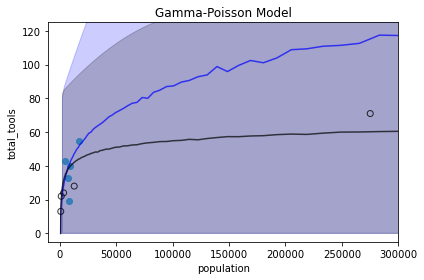

In [13]:
az.plot_hdi(P_seq, lam1_12, color="b", fill_kwargs={"alpha": 0.2})
plt.plot(P_seq, lmu1_12, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0_12, color="k", fill_kwargs={"alpha": 0.2})
plt.plot(P_seq, lmu0_12, color="k", alpha=0.7)

idx = contact_id == 1
plt.scatter(data.population[~idx],
           data.total_tools[~idx],
           facecolors="none",
           edgecolors="k",
           alpha=0.8,
           lw=1)

plt.scatter(data.population[idx], data.total_tools[idx], alpha=0.8)
plt.xlim((-10_000, 300_000))
plt.ylim((-5, 125))
plt.xlabel("population")
plt.ylabel("total_tools")
plt.title("Gamma-Poisson Model")
plt.tight_layout()

#### This looks a little off compared to the book but the intuition remains. The blue line is the high contact mean whilst the black line is the low contact mean. In this notebook http://127.0.0.1:8888/notebooks/glm_poisson_regression.ipynb we see that  Hawaii was a highly influential point in thepure Poisson model. It does all the work of pulling the low-contact trend down. In this new model, Hawaii is still influential, but it exerts a lot less influence on the trends.  This is because the gamma-Poisson model expects rate variation, and the estimated amount of variation is quite large. Population is still strongly related to the total tools, but the influence of contact rate has greatly diminished
